In [23]:
import squigglepy as sq
import numpy as np

from pprint import pprint

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from params import doubling_time, acceleration

O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

Loaded libraries


In [2]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: o3 at 1.75hr on {O3_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()

# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)

quarters = []
# Start with Q2 2025 since o3 launched in April
for year in range(2025, 2030):
    start_q = 2 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)
accel_samples = sq.sample(acceleration, n=n_samples)

print(f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}")
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_o3 = (quarter_date - O3_LAUNCH_DATE).days
    
    if days_from_o3 < 0:
        continue
    
    # Use the calculate_doubling_time function logic
    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        if accel_samples[i] == 1:
            # Simple exponential
            doublings = days_from_o3 / tau_samples[i]
            task_lengths[i] = 1.75 * (2 ** doublings)
        else:
            # Superexponential - use binary search
            low, high = 0, 100
            tau0 = tau_samples[i]
            a = accel_samples[i]
            
            for _ in range(50):
                mid = (low + high) / 2
                predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 and a > 0 and not np.isnan(a) else mid * tau0
                
                if predicted_days < days_from_o3:
                    low = mid
                else:
                    high = mid
            
            doublings = (low + high) / 2
            task_lengths[i] = 1.75 * (2 ** doublings)
    
    # Cap at reasonable maximum
    task_lengths = np.minimum(task_lengths, 2000)
    
    # Calculate statistics
    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)
    
    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")
    
    print(f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_o3:>4}")
    
    results.append({
        'quarter': f"{year}Q{q}",
        'date': quarter_date,
        'mean': mean_val,
        'median': median_val,
        'p5': p5,
        'p95': p95,
        'days': days_from_o3,
        'task_lengths': task_lengths
    })
    
    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [(2, "2 hours"), (4, "4 hours"), (8, "1 day"), 
              (16, "2 days"), (24, "3 days"), (40, "1 week"), (174, "1 month")]

for hours, name in milestones:
    for r in results:
        if r['median'] >= hours:
            prob = np.mean(r['task_lengths'] >= hours) * 100
            date_str = r['date'].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: o3 at 1.75hr on 2025-04-16

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q2       2025-06-30   2.4hr      2.3hr      [2.1hr - 2.7hr]             75
2025Q3       2025-09-30   3.6hr      3.2hr      [2.8hr - 4.7hr]            167
2025Q4       2025-12-31   5.9hr      4.6hr      [3.5hr - 1.0d]             259

2026Q1       2026-03-31   1.2d       6.4hr      [4.5hr - 1.8d]             349
2026Q2       2026-06-30   1.9d       1.1d       [5.8hr - 3.2d]             440
2026Q3       2026-09-30   3.3d       1.6d       [7.5hr - 1.1wk]            532
2026Q4       2026-12-31   1.1wk      2.2d       [1.2d - 2.1wk]             624

2027Q1       2027-03-31   1.7wk      3.1d       [1.5d - 3.7wk]             714
2027Q2       2027-06-30   2.7wk      4.4d       [1.9d - 6.6wk]             805
2027Q3       2027-09-30 

/Users/peterwildeford/dev/agi_timelines/libs.py:335: RuntimeWarning: overflow encountered in scalar power
  val *= 2 ** (DAYS_PER_QUARTER / tau)


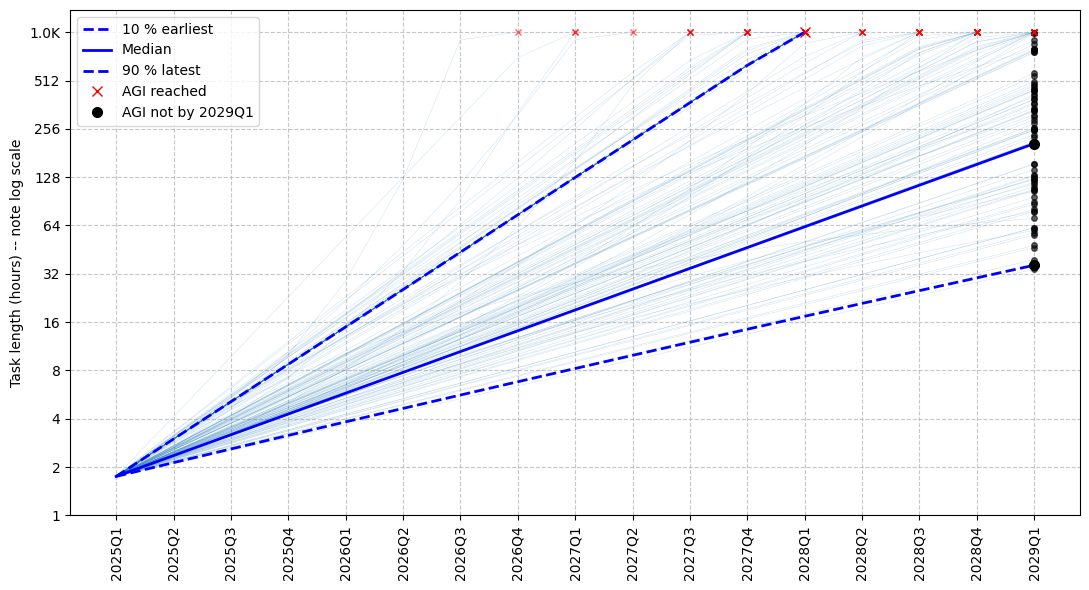

In [3]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=1.75,
    agi_task_length=100_000,
    shift=0,
    acceleration=acceleration,
    n_quarters=16,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [8]:
print("PREDICT CLAUDE 4")

claude_4_launch_date = datetime(2025, 5, 22)
days_since_o3 = (claude_4_launch_date - O3_LAUNCH_DATE).days

def model():
    doublings = days_since_o3 / doubling_time
    effective_doublings = doublings ** acceleration
    return 1.75 * (2 ** effective_doublings)

print("Model predictions for Claude 4")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: Claude 4 Opus at ~1.1-1.3 hours')

PREDICT CLAUDE 4
Model predictions for Claude 4
Predicted: 2.0hr (1.9hr - 2.2hr)
Actual observed: Claude 4 Opus at ~1.1-1.3 hours


In [9]:
print("Sanity Check - Current State")

today = datetime(2025, 7, 28)
days_since_o3 = (today - O3_LAUNCH_DATE).days
print('')
print(f"Days since o3: {days_since_o3}")
print('')
print(f"Model predictions for PUBLIC models on {today.date()}")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: Claude 4 Opus at ~1.1-1.3 hours')

Sanity Check - Current State

Days since o3: 103

Model predictions for PUBLIC models on 2025-07-28
Predicted: 2.7hr (2.3hr - 3.2hr)
Actual observed: Claude 4 Opus at ~1.1-1.3 hours


In [11]:
print("PREDICT GPT5")

today = datetime(2025, 7, 28)
days_o3_to_today = (today - O3_LAUNCH_DATE).days
days_today_to_gpt5 = sq.lognorm(5, 25)
days_since_o3 = days_o3_to_today + days_today_to_gpt5
print("Model predictions for GPT-5")
samples = sq.sample(model, n=50_000)
mean_ci = sq.get_mean_and_ci(samples)
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: ???')
print('-')
print(f"p(>4) = {round(np.mean(samples > 4) * 100)}%")

PREDICT GPT5
Model predictions for GPT-5
Predicted: 2.9hr (2.4hr - 3.6hr)
Actual observed: ???
-
p(>4) = 2%


In [25]:
print("PREDICT GPT5 [AGGRESSIVE]")

today = datetime(2025, 7, 28)
days_o3_to_today = (today - O3_LAUNCH_DATE).days
days_today_to_gpt5 = sq.lognorm(5, 25)
days_since_o3 = days_o3_to_today + days_today_to_gpt5
print("[AGGRESSIVE] Model predictions for GPT-5")
def model():
    doublings = days_since_o3 / 98
    effective_doublings = doublings ** 0.9
    return 1.75 * (2 ** effective_doublings)

samples = sq.sample(model, n=50_000)
mean_ci = sq.get_mean_and_ci(samples)
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print('Actual observed: ???')
print('-')
print(f"p(>4) = {round(np.mean(samples > 4) * 100)}%")

PREDICT GPT5 [AGGRESSIVE]
[AGGRESSIVE] Model predictions for GPT-5
Predicted: 3.9hr (3.7hr - 4.2hr)
Actual observed: ???
-
p(>4) = 22%


In [27]:
samples = sq.norm(2.4, 3.6, credibility=50) @ 50_000
pprint(sq.get_percentiles(samples, digits=1))
print('-')
print(f"p(>4) = {round(np.mean(samples > 4) * 100)}%")

{1: 0.9,
 5: 1.5,
 10: 1.9,
 20: 2.2,
 30: 2.5,
 40: 2.8,
 50: 3.0,
 60: 3.2,
 70: 3.5,
 80: 3.7,
 90: 4.1,
 95: 4.4,
 99: 5.1}
-
p(>4) = 13%


In [ ]:
# https://docs.google.com/document/d/1SigXN555dUbO-zYXfUjAAJV5kfoYuW_ZPZg_Y9qBio8/edit?tab=t.0